In [4]:
from tavily import TavilyClient
from pymed_paperscraper import PubMed
from langchain_ollama.llms import OllamaLLM
from langchain.prompts import ChatPromptTemplate
from langgraph.graph import END, StateGraph
from typing import TypedDict
import regex as re
import getpass
import os

if not os.environ.get("TAVILY_API_KEY"):
    os.environ["TAVILY_API_KEY"] = getpass.getpass("Tavily API key:\n")

TAVILY_API_KEY = os.environ.get("TAVILY_API_KEY")


class State(TypedDict):
    query: str
    messages: list
    search_results: list
    sources: list
    keywords: list
    iteration: int


llm = OllamaLLM(model="gemma3:1b-it-qat", temperature=0.5, top_k=3, top_p=5)

prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            "Namamu adalah 'Yuzuriha'. Kamu adalah chatbot AI yang menjawab dalam bahasa Indonesia. "
            "Jika tidak tahu jawabannya, minta maaf.",
        ),
        ("human", "{chat_human}"),
    ]
)

classifier_internet_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            "Kamu adalah AI classifier. "
            "Jika pertanyaan user membutuhkan data FAKTUAL, TERKINI, atau SPESIFIK "
            "(misalnya: berita, tokoh baru, data tahun tertentu, hasil pertandingan, janji politik, kebijakan, dsb), "
            "maka keluarkan 'NEED_SEARCH'. "
            "Jika pertanyaan bersifat umum, konseptual, atau bisa dijawab dengan pengetahuan dasar yang stabil, "
            "keluarkan 'NO_SEARCH'. "
            "Jangan pernah menebak. Output hanya salah satu: NEED_SEARCH atau NO_SEARCH.",
        ),
        ("human", "{chat_human}"),
    ]
)

planner_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            "You are an AI information search planner. "
            "Your task: create a logical, step-by-step search plan "
            "that will allow answering the user’s question thoroughly. "
            "Always think carefully before deciding. "
            "If the initial plan feels incomplete, refine it by adding more specific queries "
            "until the plan looks sufficient. "
            "The final output must ONLY be a valid Python list of search queries, "
            "for example: ['query1', 'query2', 'query3']. "
            "Do not include explanations, only the Python list inline, its important!.",
        ),
        ("human", "{chat_human}"),
    ]
)


aggregator_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            "Kamu adalah AI yang menggabungkan hasil pencarian internet menjadi jawaban komprehensif. "
            "Jawablah dalam bahasa Indonesia yang jelas dan singkat.",
        ),
        ("human", "Pertanyaan user: {query}\n\nHasil pencarian:\n{search_results}"),
    ]
)

pubmed_classifier_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            "Kamu adalah AI classifier untuk PubMed. "
            "Jika pertanyaan user berhubungan dengan KESEHATAN (misalnya penyakit, obat-obatan, gaya hidup, terapi, vaksin, nutrisi, dsb), "
            "jawab dengan 'SEARCH_PUBMED'. "
            "Jika tidak berhubungan dengan kesehatan, jawab dengan 'NO_PUBMED'. "
            "Jangan pernah menebak. Output hanya salah satu: SEARCH_PUBMED atau NO_PUBMED.",
        ),
        ("human", "{chat_human}"),
    ]
)

pubmed_planner_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            "You are an AI PubMed query planner. "
            "Your job: ubah pertanyaan user menjadi query pencarian yang cocok untuk PubMed. "
            "Output HARUS berupa list Python valid, contoh: ['tuberculosis treatment', 'tb vaccine']. "
            "Jangan ada penjelasan, hanya list Python inline.",
        ),
        ("human", "{chat_human}"),
    ]
)

pubmed_aggregator_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            "Kamu adalah AI yang meringkas hasil abstrak jurnal dari PubMed. "
            "Buat jawaban singkat, jelas, dalam bahasa Indonesia, "
            "dan sebutkan jika ada keterbatasan (misalnya data terbatas atau hasil tidak relevan).",
        ),
        ("human", "Pertanyaan user: {query}\n\nAbstract hasil PubMed:\n{abstracts}"),
    ]
)

def chatbot(state: State):
    user_input = state["query"]
    formatted_prompt = prompt.format_messages(chat_human=user_input)

    print(">>> Generating response (stream): ", end="", flush=True)
    response_text = ""
    for token in llm.stream(formatted_prompt):
        print(token, end="", flush=True)
        response_text += token
    print()

    return {
        **state,
        "messages": state.get("messages", []) + [response_text],
    }


def llm_classifier(state: State):
    print(">>> Llm classifier process")
    formatted_prompt_classifier = classifier_internet_prompt.format_messages(
        chat_human=state["query"]
    )
    response = llm.invoke(formatted_prompt_classifier)
    print(response)
    return {**state, "messages": state["messages"] + [response]}


def route_classifier(state: State):
    if "NEED_SEARCH" in state["messages"][-1]:
        return "planner"
    else:
        return "model_llm"


MAX_ITER = 3


def route_planner_loop(state: State):
    iteration = state.get("iteration", 0) + 1
    if len(state.get("search_results", [])) < 2 and iteration < MAX_ITER:
        return "planner"
    return "aggregator_llm"


def planner_node(state: State):
    iteration = state.get("iteration", 0) + 1
    formatted_prompt = planner_prompt.format_messages(chat_human=state["query"])
    response = llm.invoke(formatted_prompt)

    print(f">>> Planner raw response (iter {iteration}): {response}")

    match = re.search(r"\[(.*?)\]", response)
    if match:
        plan = [item.strip().strip("'\"") for item in match.group(1).split(",")]
    else:
        plan = []

    print(f">>> Iteration {iteration} parsed plan: {plan}")
    return {
        **state,
        "messages": state["messages"] + [f"Iteration {iteration} Plan: {plan}"],
        "keywords": plan,
        "iteration": iteration,
    }


def executor_node(state: State):
    print(">>> Executor start")
    client = TavilyClient(api_key=TAVILY_API_KEY)

    results, sources = [], []
    for k in state.get("keywords", []):
        print(f">>> Tavily search query: {k}")
        tool = client.search(query=k, max_results=3, topic="general")
        for r in tool["results"]:
            print(f"--- {r['url']}")
        results.extend([r["content"] for r in tool["results"]])
        sources.extend([r["url"] for r in tool["results"]])

    print(f">>> Executor collected {len(results)} results")
    return {
        **state,
        "search_results": results,
        "sources": sources,
        "messages": state["messages"] + [f"Executor found {len(results)} results"],
    }


def aggregator_llm(state: State):
    print("aggregator llm start")
    formatted_prompt = aggregator_prompt.format_messages(
        query=state["query"], search_results="\n".join(state["search_results"])
    )

    response = llm.invoke(formatted_prompt)

    print("\n\n>>> Sources used:")
    for s in state["sources"]:
        print("-", s)

    return {**state, "messages": state["messages"] + [response]}

def pubmed_classifier(state: State):
    print(">>> PubMed classifier process")
    formatted_prompt = pubmed_classifier_prompt.format_messages(
        chat_human=state["query"]
    )
    response = llm.invoke(formatted_prompt)
    print(">>> PubMed classifier result:", response)
    return {**state, "messages": state["messages"] + [response]}


def route_pubmed_classifier(state: State):
    if "SEARCH_PUBMED" in state["messages"][-1]:
        return "pubmed_planner"
    else:
        return "internet_search_classifier"


def pubmed_planner_node(state: State):
    formatted_prompt = pubmed_planner_prompt.format_messages(chat_human=state["query"])
    response = llm.invoke(formatted_prompt)
    print(">>> PubMed planner raw:", response)

    match = re.search(r"\[(.*?)\]", response)
    if match:
        plan = [item.strip().strip("'\"") for item in match.group(1).split(",")]
    else:
        plan = []

    return {
        **state,
        "keywords": plan,
        "messages": state["messages"] + [f"PubMed Plan: {plan}"],
    }


def pubmed_executor_node(state: State):
    print(">>> PubMed executor start")
    pubmed = PubMed(tool="AlifScraper", email="aliffaturrohman11@gmail.com")

    abstracts, sources = [], []
    for k in state.get("keywords", []):
        print(f">>> PubMed search query: {k}")
        results = pubmed.query(k, max_results=1)
        for article in results:
            if article.abstract:
                abstracts.append(article.abstract)
                sources.append(article.doi or article.journal)

    return {
        **state,
        "search_results": abstracts,
        "sources": sources,
        "messages": state["messages"] + [f"PubMed found {len(abstracts)} abstracts"],
    }


def pubmed_aggregator_llm(state: State):
    formatted_prompt = pubmed_aggregator_prompt.format_messages(
        query=state["query"], abstracts="\n\n".join(state["search_results"])
    )
    response = llm.invoke(formatted_prompt)

    print("\n\n>>> PubMed Sources used:")
    for s in state["sources"]:
        print("-", s)

    return {**state, "messages": state["messages"] + [response]}

graph = StateGraph(State)
graph.set_entry_point("pubmed_classifier")

graph.add_node("pubmed_classifier", pubmed_classifier)
graph.add_node("pubmed_planner", pubmed_planner_node)
graph.add_node("pubmed_executor", pubmed_executor_node)
graph.add_node("pubmed_aggregator", pubmed_aggregator_llm)

graph.add_node("internet_search_classifier", llm_classifier)
graph.add_node("model_llm", chatbot)
graph.add_node("planner", planner_node)
graph.add_node("executor", executor_node)
graph.add_node("aggregator_llm", aggregator_llm)

graph.add_conditional_edges(
    "pubmed_classifier",
    route_pubmed_classifier,
    {
        "pubmed_planner": "pubmed_planner",
        "internet_search_classifier": "internet_search_classifier",
    },
)

graph.add_edge("pubmed_planner", "pubmed_executor")
graph.add_edge("pubmed_executor", "pubmed_aggregator")
graph.add_edge("pubmed_aggregator", END)

# routing internet lama
graph.add_conditional_edges(
    "internet_search_classifier",
    route_classifier,
    {"planner": "planner", "model_llm": "model_llm"},
)
graph.add_edge("planner", "executor")
graph.add_conditional_edges(
    "executor",
    route_planner_loop,
    {"planner": "planner", "aggregator_llm": "aggregator_llm"},
)
graph.add_edge("model_llm", END)
graph.add_edge("aggregator_llm", END)

app = graph.compile()

DEBUG:urllib3.connectionpool:Starting new HTTPS connection (1): mermaid.ink:443
DEBUG:urllib3.connectionpool:https://mermaid.ink:443 "GET /img/LS0tCmNvbmZpZzoKICBmbG93Y2hhcnQ6CiAgICBjdXJ2ZTogbGluZWFyCi0tLQpncmFwaCBURDsKCV9fc3RhcnRfXyhbPHA+X19zdGFydF9fPC9wPl0pOjo6Zmlyc3QKCXB1Ym1lZF9jbGFzc2lmaWVyKHB1Ym1lZF9jbGFzc2lmaWVyKQoJcHVibWVkX3BsYW5uZXIocHVibWVkX3BsYW5uZXIpCglwdWJtZWRfZXhlY3V0b3IocHVibWVkX2V4ZWN1dG9yKQoJcHVibWVkX2FnZ3JlZ2F0b3IocHVibWVkX2FnZ3JlZ2F0b3IpCglpbnRlcm5ldF9zZWFyY2hfY2xhc3NpZmllcihpbnRlcm5ldF9zZWFyY2hfY2xhc3NpZmllcikKCW1vZGVsX2xsbShtb2RlbF9sbG0pCglwbGFubmVyKHBsYW5uZXIpCglleGVjdXRvcihleGVjdXRvcikKCWFnZ3JlZ2F0b3JfbGxtKGFnZ3JlZ2F0b3JfbGxtKQoJX19lbmRfXyhbPHA+X19lbmRfXzwvcD5dKTo6Omxhc3QKCV9fc3RhcnRfXyAtLT4gcHVibWVkX2NsYXNzaWZpZXI7CglleGVjdXRvciAtLi0+IGFnZ3JlZ2F0b3JfbGxtOwoJZXhlY3V0b3IgLS4tPiBwbGFubmVyOwoJaW50ZXJuZXRfc2VhcmNoX2NsYXNzaWZpZXIgLS4tPiBtb2RlbF9sbG07CglpbnRlcm5ldF9zZWFyY2hfY2xhc3NpZmllciAtLi0+IHBsYW5uZXI7CglwbGFubmVyIC0tPiBleGVjdXRvcjsKCXB1Ym1lZF9jbGFzc2lmaWVyIC0uLT4ga

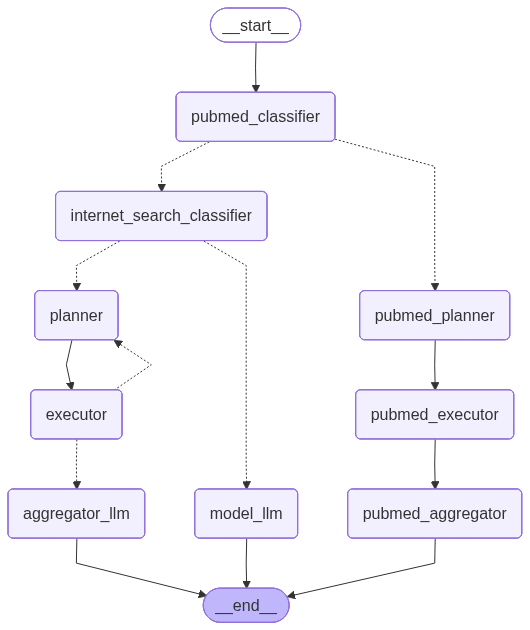

In [2]:
app

In [3]:
input_user = {
    "query": "Apa penyebab dari tubercolosis?",
    "messages": [],
    "search_results": [],
    "sources": [],
    "iteration": 0,
}
final_state = app.invoke(input_user)

print("\n\n>>> Final Answer:", final_state["messages"][-1])

>>> PubMed classifier process
DEBUG:httpcore.connection:connect_tcp.started host='127.0.0.1' port=11434 local_address=None timeout=None socket_options=None
DEBUG:httpcore.connection:connect_tcp.complete return_value=<httpcore._backends.sync.SyncStream object at 0x7c57e70eb680>
DEBUG:httpcore.http11:send_request_headers.started request=<Request [b'POST']>
DEBUG:httpcore.http11:send_request_headers.complete
DEBUG:httpcore.http11:send_request_body.started request=<Request [b'POST']>
DEBUG:httpcore.http11:send_request_body.complete
DEBUG:httpcore.http11:receive_response_headers.started request=<Request [b'POST']>


DEBUG:httpcore.http11:receive_response_headers.complete return_value=(b'HTTP/1.1', 200, b'OK', [(b'Content-Type', b'application/x-ndjson'), (b'Date', b'Thu, 25 Sep 2025 16:56:01 GMT'), (b'Transfer-Encoding', b'chunked')])
INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/generate "HTTP/1.1 200 OK"
DEBUG:httpcore.http11:receive_response_body.started request=<Request [b'POST']>
DEBUG:httpcore.http11:receive_response_body.complete
DEBUG:httpcore.http11:response_closed.started
DEBUG:httpcore.http11:response_closed.complete
>>> PubMed classifier result: SEARCH_PUBMED

DEBUG:httpcore.http11:send_request_headers.started request=<Request [b'POST']>
DEBUG:httpcore.http11:send_request_headers.complete
DEBUG:httpcore.http11:send_request_body.started request=<Request [b'POST']>
DEBUG:httpcore.http11:send_request_body.complete
DEBUG:httpcore.http11:receive_response_headers.started request=<Request [b'POST']>
DEBUG:httpcore.http11:receive_response_headers.complete return_value=(b'HTTP/1.1', 2

In [8]:
input_user1 = {
    "query": "Analisis tren bencana alam di Indonesia selama 50 tahun terakhir dan identifikasi bencana dengan dampak ekonomi terbesar. Buat perbandingan antara jumlah korban jiwa, kerugian finansial, dan area terdampak. Sertakan prediksi apakah tren bencana akan meningkat atau menurun dalam 10 tahun ke depan berdasarkan data historis.",
    "messages": [],
    "search_results": [],
    "sources": [],
    "iteration": 0,
}

final_state1 = app.invoke(input_user1)

print("\n\n>>> Final Answer:", final_state1["messages"][-1])


>>> Llm classifier process
NEED_SEARCH

>>> Planner raw response (iter 1): ['Indonesia disaster history analysis 50 years, economic impact analysis, comparison of casualties, financial losses, and affected areas, historical trend prediction for future years']
>>> Iteration 1 parsed plan: ['Indonesia disaster history analysis 50 years', 'economic impact analysis', 'comparison of casualties', 'financial losses', 'and affected areas', 'historical trend prediction for future years']
>>> Executor start
>>> Tavily search query: Indonesia disaster history analysis 50 years
--- https://www.researchgate.net/publication/362424224_A_50-years_flood_frequency_in_Coastal_area_of_Java_Indonesia_Integrating_historical_hotspot_and_Spatial_Autocorrelation_Analysis
--- https://www.youtube.com/watch?v=BhvW3llLaEQ
--- https://muse.jhu.edu/article/862539
>>> Tavily search query: economic impact analysis
--- https://facilities.unc.edu/wp-content/uploads/sites/256/2015/12/economic_impact.pdf
--- https://www.r